In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import matplotlib as mpl


FONT_SIZE = 12
AXES_SIZE = FONT_SIZE * 1.5
TICK_SIZE = FONT_SIZE * 1.25
LEGEND_SIZE = FONT_SIZE

my_rcParams = {
    "axes.spines.top": False,
    "axes.spines.right": False,
    "lines.linewidth": 5,
    "font.size": FONT_SIZE,
    "font.family": "Helvetica",
    "axes.titlesize": AXES_SIZE,
    "axes.labelsize": AXES_SIZE,
    "xtick.labelsize": TICK_SIZE,
    "ytick.labelsize": TICK_SIZE,
    "legend.fontsize": LEGEND_SIZE,
    "xtick.major.pad": FONT_SIZE / 2,
    "ytick.major.pad": FONT_SIZE / 2,
}

for k, v in my_rcParams.items():
    mpl.rcParams[k] = v

In [3]:
errors_df = pd.read_csv("../errors/down_scaled_errors.tsv", sep="\t")

In [4]:
threses = errors_df["thres"].unique()

In [5]:
errors_df.head()

,location,model,thres,pivot_date,lead,variant,MAE,RMSE,loglik,total_seq,raw_freq,smoothed_freq,pred_freq,date
0,United Kingdom,MLR,100,2022-01-01,-68,Delta,0.000004,0.000004,-1.466410,6579.0,0.999848,0.999646,0.999651,2021-10-25
1,United Kingdom,MLR,100,2022-01-01,-67,Delta,0.000078,0.000078,-1.571925,6315.0,0.999525,0.999702,0.999624,2021-10-26
2,United Kingdom,MLR,100,2022-01-01,-66,Delta,0.000085,0.000085,-1.510297,6694.0,0.999552,0.999680,0.999595,2021-10-27
3,United Kingdom,MLR,100,2022-01-01,-65,Delta,0.000099,0.000099,-3.447540,5926.0,0.998988,0.999661,0.999561,2021-10-28
4,United Kingdom,MLR,100,2022-01-01,-64,Delta,0.000158,0.000158,-2.590464,5442.0,1.000000,0.999683,0.999524,2021-10-29


In [6]:
# Filter to three leads of interest
errors = errors_df#[errors_df.lead.isin(DAYS_TO_PLOT_ERROR)]
mean_mae = (errors[["thres", "lead", "pivot_date", "MAE"]] # Why does mean lead differ?
    .groupby(["thres", "lead"])
    .agg({'MAE':['mean','sem']})
    .reset_index()
)
mean_mae.columns = ['thres', 'lead', 'MAE_mean', 'MAE_sem']

In [7]:
errors

,location,model,thres,pivot_date,lead,variant,MAE,RMSE,loglik,total_seq,raw_freq,smoothed_freq,pred_freq,date
0,United Kingdom,MLR,100,2022-01-01,-68,Delta,0.000004,0.000004,-1.466410,6579.0,0.999848,0.999646,9.996506e-01,2021-10-25
1,United Kingdom,MLR,100,2022-01-01,-67,Delta,0.000078,0.000078,-1.571925,6315.0,0.999525,0.999702,9.996241e-01,2021-10-26
2,United Kingdom,MLR,100,2022-01-01,-66,Delta,0.000085,0.000085,-1.510297,6694.0,0.999552,0.999680,9.995946e-01,2021-10-27
3,United Kingdom,MLR,100,2022-01-01,-65,Delta,0.000099,0.000099,-3.447540,5926.0,0.998988,0.999661,9.995614e-01,2021-10-28
4,United Kingdom,MLR,100,2022-01-01,-64,Delta,0.000158,0.000158,-2.590464,5442.0,1.000000,0.999683,9.995241e-01,2021-10-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38380,United Kingdom,MLR,5000,2022-12-01,26,Omicron 21L,0.002255,0.002255,-29.200175,976.0,0.002049,0.002255,6.615314e-10,2022-12-27
38381,United Kingdom,MLR,5000,2022-12-01,27,Omicron 21L,0.002760,0.002760,-89.584267,1715.0,0.003499,0.002760,5.731474e-10,2022-12-28
38382,United Kingdom,MLR,5000,2022-12-01,28,Omicron 21L,0.002611,0.002611,-59.450633,1566.0,0.002554,0.002611,4.964860e-10,2022-12-29
38383,United Kingdom,MLR,5000,2022-12-01,29,Omicron 21L,0.002694,0.002694,-45.465196,1108.0,0.002708,0.002694,4.300066e-10,2022-12-30


In [8]:
def simplify_axes(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

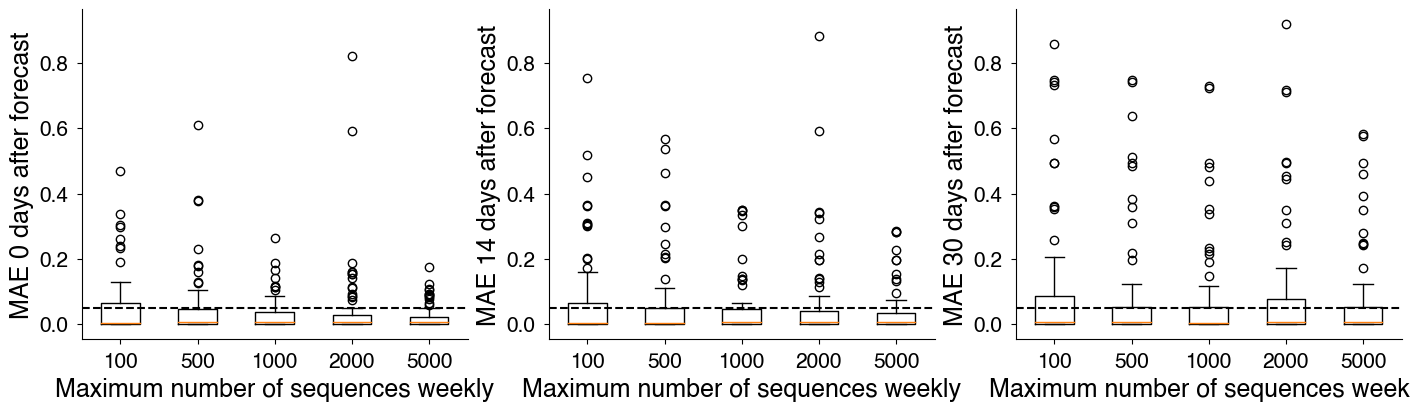

In [29]:
# Plot MAE over lead for each threshold
fig = plt.figure(figsize=(14., 4.), constrained_layout=True)
spec = fig.add_gridspec(ncols=3, nrows=1)

# What should panels be 


def plot_error_by_thres_at_lead(ax, errors, lead, ylabel=None):
    _errors = errors.copy()
    if lead is not None:
        _errors = _errors[_errors.lead == lead]

    mean_errors_by_thres = _errors.groupby("thres").agg({'MAE':['mean','sem']}).reset_index()    
    ax.plot(_errors.thres, _errors.MAE, ec="k", alpha=0.5)
    ax.errorbar(mean_errors_by_thres.thres, 
                mean_errors_by_thres.MAE["mean"], 
                yerr=2*mean_errors_by_thres.MAE["sem"],
                color="k",
                linewidth=2.5)


    ax.set_xscale("log")
    ax.set_xlabel("Maximum # of sequences weekly")
    ax.set_ylabel(ylabel)
    
def plot_error_by_thres_at_lead(ax, errors, lead, ylabel=None, desired_thres=0.05):
    _errors = errors.copy()
    if lead is not None:
        _errors = _errors[_errors.lead == lead]
        
    ax.boxplot([df.MAE for n,df in _errors.groupby("thres")])
    ax.set_xticklabels([n for n,df in _errors.groupby("thres")])
    
    ax.axhline(y=desired_thres, color="k", linestyle="--", linewidth=1.5)
    ax.set_xlabel("Maximum number of sequences weekly")
    ax.set_ylabel(ylabel)

    
leads_to_plot = [0, 14, 30]
for l, lead in enumerate(leads_to_plot):
    ax = fig.add_subplot(spec[l])
    
    if l == 0:
        ax0 = ax
    else:
        ax.sharey(ax0)
        
    simplify_axes(ax)
    plot_error_by_thres_at_lead(ax, errors, lead, ylabel=f"MAE {lead} days after forecast")

# Change y-axes lo

In [12]:
def plot_error_by_thres(ax, mean_mae, lead, ylabel=None):
    _mean_mae = mean_mae.copy()
    if lead is not None:
        _mean_mae = _mean_mae[_mean_mae.lead == lead]
    
    mean_errors_by_thres = _mean_mae.groupby("thres").agg({'MAE_mean':['mean','sem']}).reset_index()    
    ax.scatter(_mean_mae.thres, _mean_mae.MAE_mean, ec="k", alpha=0.3)
    ax.errorbar(mean_errors_by_thres.thres, 
                mean_errors_by_thres.MAE_mean["mean"], 
                #yerr=2*mean_errors_by_thres.MAE_mean["sem"],
                color="k",
                linewidth=2.5)


    ax.set_xscale("log")
    ax.set_xlabel(ylabel)
    ax.set_ylabel("Average MAE over all leads")

In [13]:
threses

array([ 100,  500, 1000, 2000, 5000])

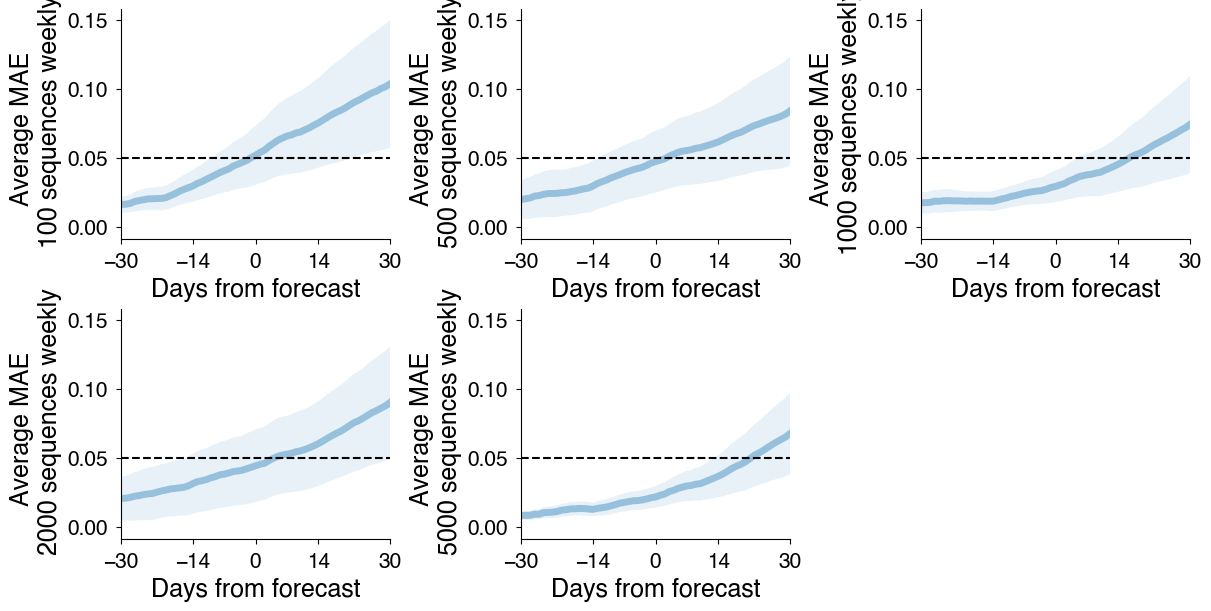

In [28]:
# Plot MAE over lead for each threshold
fig = plt.figure(figsize=(12., 6.), constrained_layout=True)
spec = fig.add_gridspec(ncols=3, nrows=2)

def plot_error_by_thres(ax, mean_mae, thres, ylabel=None, desired_thres=0.05):
    _mean_mae = mean_mae.copy()
    if lead is not None:
        _mean_mae = _mean_mae[_mean_mae.thres == thres]
    
    ax.plot(_mean_mae.lead, _mean_mae.MAE_mean, alpha=0.4)
    ax.fill_between(_mean_mae.lead, 
                    _mean_mae.MAE_mean - 2*_mean_mae.MAE_sem, 
                    _mean_mae.MAE_mean + 2*_mean_mae.MAE_sem,
                    alpha=0.1)

    ax.set_xlabel("Days from forecast")
    ax.set_ylabel(ylabel)
    ax.axhline(y=desired_thres, color="k", linestyle="--", linewidth=1.5)

for t, thres in enumerate(threses):
    ax = fig.add_subplot(spec[t])
    
    if t == 0:
        ax0 = ax
    else:
        ax.sharey(ax0)
        
    simplify_axes(ax)
    plot_error_by_thres(ax, mean_mae, thres, ylabel=f"Average MAE \n {thres} sequences weekly")
    ax.set_xlim((-30,30))
    ax.set_xticks([-30, -14, 0, 14, 30]) # Can find first point you cross accuracy threshold @ each sequencing thres
    
# Need to repeat for given leads
# Picking thresholds that are like actual historical / country-like rates

# Can we make a companion figure for this that shows what each countries sequencing effort 
# looks like currently in terms of sequences weekly (can tie in colors from rest of manuscript)

In [18]:
# Porportion less than desired_threshold

In [19]:
desired_thres=0.05

errors["acceptable"] = (errors.MAE < desired_thres)

mean_acceptable = (errors[["thres", "lead", "pivot_date", "acceptable"]] # Why does mean lead differ?
    .groupby(["thres", "lead"])
     .agg({'acceptable':['mean','sem']})
    .reset_index()

)
mean_acceptable.columns = ['thres', 'lead', 'acceptable_mean', 'acceptable_sem']

In [20]:
mean_acceptable

,thres,lead,acceptable_mean,acceptable_sem
0,100,-72,1.000000,0.000000
1,100,-71,1.000000,0.000000
2,100,-70,0.920000,0.055377
3,100,-69,0.920000,0.055377
4,100,-68,0.948718,0.035782
...,...,...,...,...
502,5000,26,0.728395,0.049729
503,5000,27,0.716049,0.050414
504,5000,28,0.740741,0.048995
505,5000,29,0.703704,0.051052


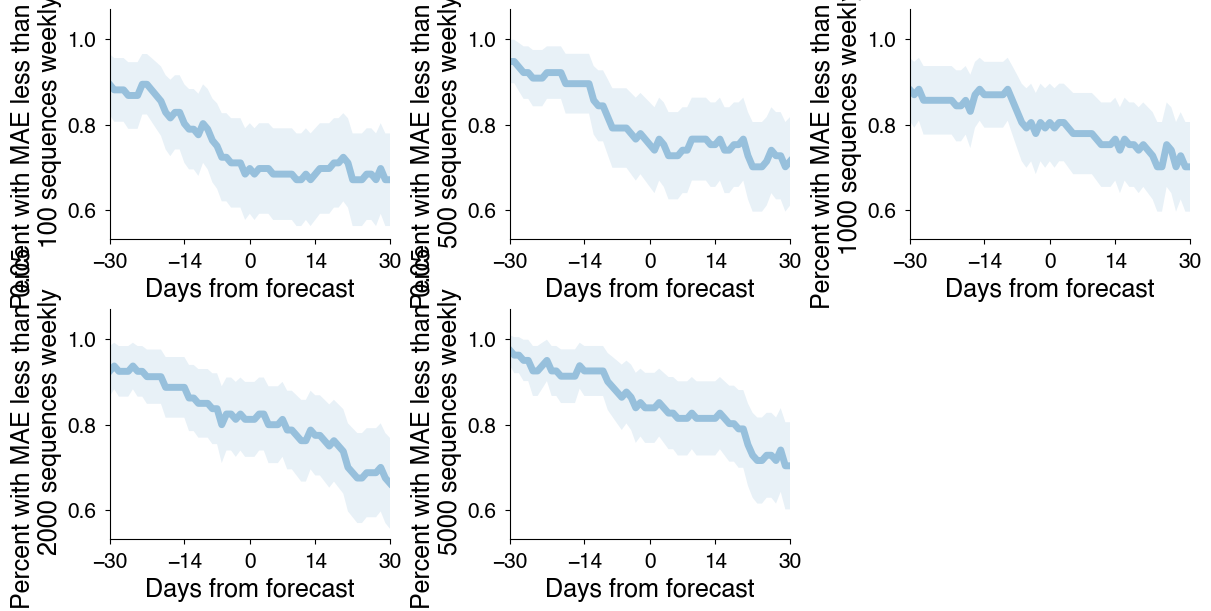

In [27]:
# Plot MAE over lead for each threshold
fig = plt.figure(figsize=(12., 6.), constrained_layout=True)
spec = fig.add_gridspec(ncols=3, nrows=2)

def plot_accept_by_thres(ax, mean_accept, thres, ylabel=None):
    _mean_accept = mean_accept.copy()
    if lead is not None:
        _mean_accept = _mean_accept[_mean_accept.thres == thres]
    
    ax.plot(_mean_accept.lead, _mean_accept.acceptable_mean, alpha=0.4)
    ax.fill_between(_mean_accept.lead, 
                    _mean_accept.acceptable_mean - 2*_mean_accept.acceptable_sem, 
                    _mean_accept.acceptable_mean + 2*_mean_accept.acceptable_sem,
                    alpha=0.1)

    ax.set_xlabel("Days from forecast")
    ax.set_ylabel(ylabel)
    
#ax = fig.add_subplot(spec[0])
for t, thres in enumerate(threses):
    ax = fig.add_subplot(spec[t])
    
    if t == 0:
        ax0 = ax
    else:
        ax.sharey(ax0)
        
    simplify_axes(ax)
    plot_accept_by_thres(ax, mean_acceptable, thres, ylabel=f"Percent with MAE less than 0.05 \n {thres} sequences weekly")
    ax.set_xlim((-30,30))
    ax.set_xticks([-30, -14, 0, 14, 30]) # Can find first point you cross accuracy threshold @ each sequencing thres



In [ ]:
# Threshold is on x-axis, Percent with MAE less than 0.05 is on y-axis?
# At different leads?

# Answers: What number of sequences should pick to ensure our forecast error is less than 0.05 x days out?

In [ ]:
# Marginal increase / decreasing in error per sequence?